In [11]:
import cv2
import cv2 as cvx
import numpy as np
from pathlib import Path

# Code for Enter key: 13
# Code for Nothing: 255
# Code for Escape: 27

import winsound
frequency = 300  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

background = None
alpha = 0.5 
'''A lower value for this variable means 
running average will be performed over a larger amount of 
previous frames and vice-versa.'''

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [2]:
contours = None
hierarchy = None

In [3]:
def calc_background(frame, alpha):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    
    '''The objective is to detect active objects from the difference obtained from 
    the reference frame and the current frame (background). We keep feeding each frame to the accumulateWeighted() function,
    and the function keeps finding the averages of all frames. '''
    
    cv2.accumulateWeighted(frame, background, alpha)

In [9]:
def detect_hand(frame, threshold=25):
    global background,contours,hierarchy
    
    diff = cv2.absdiff(background.astype("uint8"), frame) #absolute difference between hand frame and background frame
    cv2.imshow("Difference", diff)

    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY) #if pixel value >=255, 1 else 0 (Binary thresholding)

    # detects change in the image color and marks it as contour. Detection of hand before the background
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # hierarchy: contains information about image topology; number of elements equal to number of contours

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea) #sorts by contour area and finds contour with maximum area
        
        return (thresholded, hand_segment_max_cont)

In [14]:
f = True
element = 0
cam = cv2.VideoCapture(0)
cam2 = cvx.VideoCapture(0)
while f:
    
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()
    cv2.putText(frame_copy, "Enter next choice of character", (0, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(frame_copy, "Press Escape to exit", (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.imshow("Sign Language Image Data Collector", frame_copy)
    num_frames = 0
    ele0 = cv2.waitKey(1) & 0xFF
    if ele0==27: #break loop for escape
        print("breaking loop")
        break
    element = chr(ele0)
    #element = 'A'
    num_imgs_taken = 0
    print(chr(ele0)) if ele0!=255 else print(end="")
    while ele0!=255 and ele0!=13:
        ret, frame = cam.read()

        # flipping the frame to prevent inverted image of captured frame...
        frame = cv2.flip(frame, 1)

        frame_copy = frame.copy()

        roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        cv2.imshow("Gray image", gray_frame)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        if num_frames < 60:
            calc_background(gray_frame, alpha)
            cv2.putText(frame_copy, "Reading background data...", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
        #Placing the hand in the Region of Interest...
        elif num_frames <= 300: 

            hand = detect_hand(gray_frame)
            
            cv2.putText(frame_copy, "Make gesture for '"+str(element)+"'", (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Checking if hand is actually detected by counting number of contours detected...
            if hand is not None:
                
                thresholded, hand_segment = hand

                # Draw contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
                
                cv2.putText(frame_copy, str(num_frames)+" for " + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

                # Also display the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
                cv2.imshow("Blurred", gray_frame)
                print(type(hand_segment),end="\r")
        
        else: 
            
            # Segmenting the hand region...
            hand = detect_hand(gray_frame)
            # Checking if we are able to detect the hand...
            if hand is not None:
                
                # unpack the thresholded img and the max_contour...
                thresholded, hand_segment = hand

                # Drawing contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
                print(type(hand),"***")
                
                cv2.putText(frame_copy, str(num_imgs_taken) + 'images for' + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                
                # Displaying the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
                cv2.imshow("Blurred", gray_frame)
                if num_imgs_taken <= 500:
                    cv2.putText(frame_copy, 'Collected '+str(num_imgs_taken)+' training images for' + str(element), (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#                     Path("gesture/train/"+str(element)+"/").mkdir(parents=True, exist_ok=True)
#                     printed = cv2.imwrite(r"gesture/train/"+str(element)+"/"+str(num_imgs_taken) + '.jpg', thresholded)
#                     print(printed," img: ",num_imgs_taken ) if not printed else print(end="")
                    pass
                elif num_imgs_taken<=600:
                    cv2.putText(frame_copy, 'Collected '+str(num_imgs_taken)+' testing images for' + str(element), (0, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
#                     Path("gesture/test/"+str(element)+"/").mkdir(parents=True, exist_ok=True)
#                     printed = cv2.imwrite(r"gesture/test/"+str(element)+"/"+str(num_imgs_taken) + '.jpg', thresholded)
#                     print(printed," img: ",num_imgs_taken ) if not printed else print(end="")
                    pass
                else:
                    break
                num_imgs_taken+=1
            else:
                cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        # Drawing ROI on frame copy
        cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
        
        cv2.putText(frame_copy, "CSE4020 J Component - Sign Language Detection & Recognition", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
        
        # increment the number of frames for tracking
        num_frames += 1

        # Display the frame with segmented hand
        cv2.imshow("Sign Language Image Data Collector", frame_copy)

        # Closing windows with Esc key...(any other key with ord can be used too.)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
    

    #f = False
# Releasing camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

A
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> **

<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***
<class 'tuple'> ***


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_path = r'data2\train'
test_path = r'data2\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(128,128), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(128,128), class_mode='categorical', batch_size=10, shuffle=True)

imgs, labels = next(train_batches)

Found 12024 images belonging to 24 classes.
Found 2400 images belonging to 24 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
128
128
3


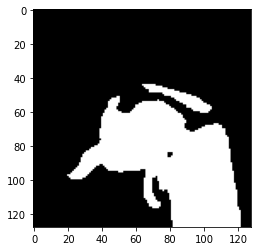

24 classes


In [3]:
import matplotlib.pyplot as plt
x = imgs
for i in range(imgs.ndim):
    print(len(x))
    x = x[0]
x = imgs[0]
fig, ax = plt.subplots()
# for img, ax in zip( x, axes):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax.imshow(img)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()
img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
ax.imshow(img)
plt.show()
print(len(labels[0]),"classes")
classes = len(labels[0])

In [4]:
model = Sequential() #initialising a sequential model to store layers of tensors

'''Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input 
which helps produce a tensor of outputs.

Kernel: In image processing kernel is a convolution matrix or a mask which can be used for blurring, 
sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image.'''

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(128,activation ="relu"))
model.add(Dense(256,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(256,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(classes,activation ="softmax"))

In [5]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


history2 = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
imgs, labels = next(train_batches) # For getting next batch of imgs...

imgs, labels = next(test_batches) # For getting next batch of imgs...
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/10
  29/1203 [..............................] - ETA: 11:56 - loss: 6.9497 - accuracy: 0.2138

KeyboardInterrupt: 

In [34]:
model.save('cse4020_CNN2.h5')